In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

### Make Data 

$$ {\cal D} = \{(x_i, y_i)\}_{i=1}^N$$
\begin{align}
y_i & = a x_i + b + \epsilon_{n,i}, \quad i=1,\ldots,N
\end{align}
$$ \epsilon_{n,i} \sim {\cal N}(0, \sigma_n^2)$$

In [3]:
a = 0.5
b = -0.5
sigma_n = 0.1

N = 20
x = 2*np.random.rand(N)-1

y = a*x + b + sigma_n * np.random.randn(N)

Text(0.5, 1.0, 'X space')

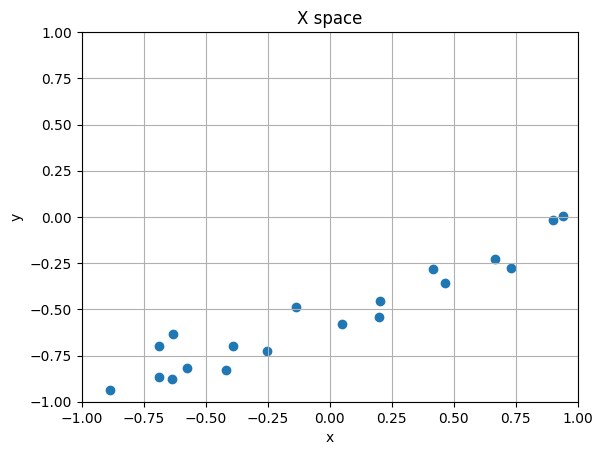

In [4]:
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid()
plt.title('X space')

#### Second dataset

$$ {\cal D} = \{(x_i, y_i)\}_{i=1}^N$$
\begin{align}
y_i & = \sin(2\pi x_i) + \epsilon_{n,i}, \quad i=1,\ldots,N
\end{align}
$$ \epsilon_{n,i} \sim {\cal N}(0, \sigma_n^2)$$

In [5]:
# sigma_n = 0.1

# N = 20
# x = 2*np.random.rand(N)-1

# y = np.sin(2*np.pi*x) + sigma_n * np.random.randn(N)

In [6]:
# plt.scatter(x, y)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.xlim([-1, 1])
# # plt.ylim([-1, 1])
# plt.grid()
# plt.title('X space')

### Likelihood model

\begin{align}
y_i & = w_1 x_i + w_2 + \epsilon_i = \mathbf{w}^\top  \mathbf{x}_i + \epsilon_i
\end{align}
$$ \mathbf{w} = (w_1, w_2) \in \mathbb{R}^2, \quad \mathbf{x}_i = (x_i, 1) \in \mathbb{R}^2$$
$$ \epsilon_i \sim {\cal N}(0, \sigma^2)$$

$$p(y|\mathbf{x},\mathbf{w}) = {\cal N}(\mathbf{w}^\top  \mathbf{x}, \sigma^2)$$

#### For multiple data

$$p(\mathbf{y}|X,\mathbf{w}) = \prod_{i=1}^N p(y_i|\mathbf{x}_i,\mathbf{w})$$
$$\mathbf{y} = (y_1, \ldots, y_N) \in \mathbb{R}^N, \quad X = [\mathbf{x}_i, \ldots, \mathbf{x}_N] \in \mathbb{R}^{2 \times N} $$

\begin{align}
\log p(\mathbf{y}|X,\mathbf{w}) & = \sum_{i=1}^N \log p(y_i|\mathbf{x}_i,\mathbf{w})\\
& = \sum_{i=1}^N - \frac{1}{2} \log(2\pi\sigma^2) -\frac{1}{2\sigma^2}(\mathbf{w}^\top \mathbf{x}_i - y_i)^2 
\end{align}

In [7]:
sigma = 0.3
X = np.stack([x, np.ones(N)])

def likelihood_model(w, X, y, sigma):
    # w shape: (dim, N_w)
    # X shape: (dim, N)
    # y shape: (N)
    log_likelihood = -0.5*np.log(2*np.pi*sigma**2) -0.5/sigma**2*(np.dot(w.T, X) - y[np.newaxis,:])**2
    return np.exp(np.sum(log_likelihood, axis=1))

In [8]:
NN = 10
w = np.random.randn(2,NN)
likelihood_model(w, X, y, sigma)

array([3.00384378e+000, 1.68681229e-256, 9.02895696e-106, 1.26812231e-070,
       3.55312612e-033, 1.30408936e-001, 4.00909922e-005, 2.50633047e-079,
       1.62525608e-208, 4.51477394e-141])

### Prior distribution

$$ \mathbf{w}=(w_1, w_2) \sim {\cal N}(0, \sigma_0^2  I) $$

$\sigma_0 = 0.5$

In [9]:
sigma0 = 0.5

In [10]:
def gaussian_pdf(x, mu, cov):
    # x shape (dim, N)
    # mu shape (dim,)
    # cov shape (dim,dim)
    dim = x.shape[0]
    
    _, logdet_cov = np.linalg.slogdet(cov)
    inv_cov = np.linalg.inv(cov)
    x_sub_mu = x.T - mu[np.newaxis,:]
    log_pdf = -0.5*dim*np.log(2*np.pi) - 0.5*logdet_cov -0.5*np.matmul(np.matmul(x_sub_mu[:,np.newaxis,:], inv_cov[np.newaxis,:,:]), x_sub_mu[:,:,np.newaxis])
    
    return np.exp(log_pdf[:,0,0])

In [11]:
def plot_prior(sigma0, plot_dot=True, w1min=-1, w1max=1, w2min=-1, w2max=1, xmin=-1, xmax=1, ymin=-1, ymax=1):
    
    mean_w_prior = np.array([0, 0])
    cov_w_prior = np.array([[sigma0**2, 0.0], [0.0, sigma0**2]])
    N_w = 10
    w_s_prior = np.random.multivariate_normal(mean_w_prior, cov_w_prior, N_w)
    
    plt.figure(figsize=(16,4))

    plt.subplot(1,4,1)
    # plt.scatter([1],[1])
    ################### prior pdf ###################
    plt.subplot(1,4,2)
    
    # Create grid
    w1s = np.linspace(w1min, w1max, 50)
    w2s = np.linspace(w2min, w2max, 100)
    W1, W2 = np.meshgrid(w1s, w2s)
    
    # Evaluate the Gaussian on the grid
    Z = gaussian_pdf(np.stack([W1.reshape(-1,),W2.reshape(-1,)]), mean_w_prior, cov_w_prior)
    
    # Create the contour plot
    contours = plt.contourf(W1, W2, Z.reshape(len(w2s), len(w1s)), levels=10, cmap='viridis')
    # plt.clabel(contours, inline=True, fontsize=8)
    if plot_dot:
        plt.scatter(a,b,c='r',marker='+', s=50, linewidths=2)
    plt.title('W space - prior pdf')
    plt.xlabel('w1-axis')
    plt.ylabel('w2-axis')
    plt.xlim([w1min, w1max])
    plt.ylim([w2min, w2max])
    # plt.grid(True)

    ################### samples from posterior ###################
    plt.subplot(1,4,3)
    x_grid = np.linspace(xmin, xmax, 101)
    for w in w_s_prior:
        plt.plot(x_grid, w[0]*x_grid + w[1], 'r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.grid()
    plt.title('X space - samples from prior')

    plt.subplot(1,4,4)
    # plt.scatter([1],[1])
    
    # Show the plot
    plt.tight_layout()
    plt.show()

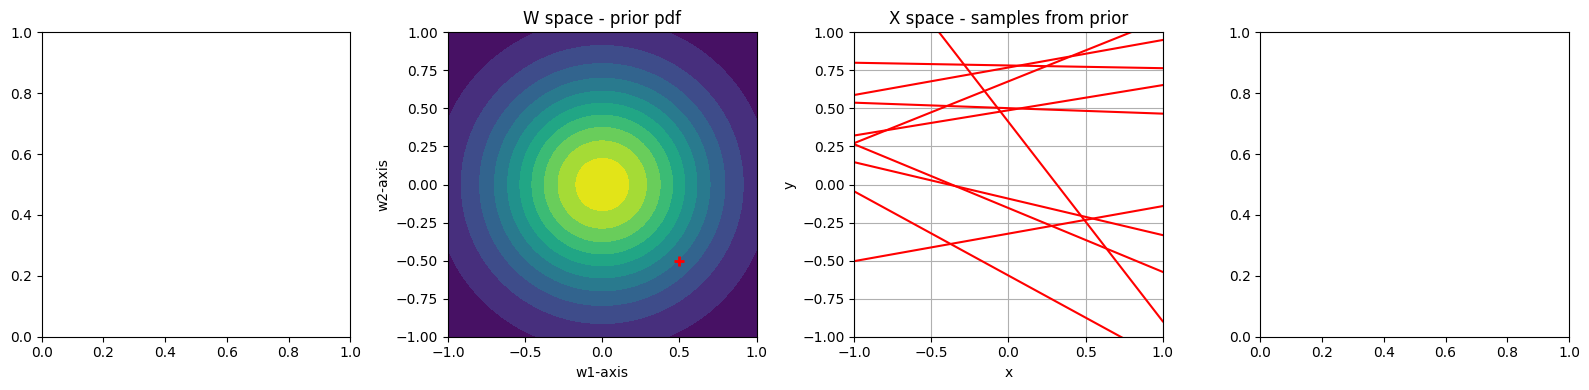

In [12]:
plot_prior(sigma0)

### Posterior distribution after observations

$$ \mathbf{w} \sim p(\mathbf{w}|X, y) = {\cal N}(\mu_w, \Sigma_w)$$
$$ \mu_w = \left(\sum_{i=1}^N \mathbf{x}_i \mathbf{x}_i^\top + \frac{\sigma^2}{\sigma_0^2} I\right)^{-1}\left(\sum_{i=1}^N \mathbf{x}_i y_i\right) = \left(XX^\top + \frac{\sigma^2}{\sigma_0^2} I\right)^{-1} X y$$
$$ \Sigma_w = \sigma^2 \left(\sum_{i=1}^N \mathbf{x}_i \mathbf{x}_i^\top + \frac{\sigma^2}{\sigma_0^2} I\right)^{-1} = \sigma^2 \left(XX^\top + \frac{\sigma^2}{\sigma_0^2} I\right)^{-1}$$

In [13]:
def posterior_mean_cov(X, y, sigma0, sigma):
    # X shape (dim, N)
    # y shape (N)
    
    # mu_w shape (dim,)
    # Sigma_w shape (dim,dim)
    
    dim = X.shape[0]
    mat = np.linalg.inv(np.dot(X, X.T) + sigma**2/sigma0**2 * np.eye(dim))
    mu_w = np.dot(mat, np.dot(X, y))
    Sigma_w = sigma**2*mat
    return mu_w, Sigma_w

### Predictive distribution

$$ y_{new} \sim {\cal N}(\mu_{y_{new}|\mathbf{x}_{new},{\cal D}}, \Sigma_{y_{new}|\mathbf{x}_{new},{\cal D}})$$
$$\mu_{y_{new}|\mathbf{x}_{new},{\cal D}} = \mathbf{x}_{new}^\top \mu_w = \mathbf{x}_{new}^\top \left(XX^\top + \frac{\sigma^2}{\sigma_0^2} I\right)^{-1} X y$$
$$\Sigma_{y_{new}|\mathbf{x}_{new},{\cal D}} = \sigma^2 +\mathbf{x}_{new}^\top \Sigma_w \mathbf{x}_{new} = \sigma^2 \left(1+\mathbf{x}_{new}^\top \left(XX^\top + \frac{\sigma^2}{\sigma_0^2} I\right)^{-1}\mathbf{x}_{new} \right)$$

In [14]:
def predictive_mean_var(Xnew, X, y, sigma0, sigma):
    # Xnew shape (dim, Nnew)
    # X shape (dim, N)
    # y shape (N)

    mu_w, Sigma_w = posterior_mean_cov(X, y, sigma0, sigma)

    XnewT = Xnew.T
    mu_ynew = np.dot(XnewT, mu_w)
    
    var_ynew = sigma**2 + np.matmul(np.matmul(XnewT[:,np.newaxis,:], Sigma_w), XnewT[:,:,np.newaxis])
    return mu_ynew, var_ynew[:,0,0]

In [15]:
def plot_predictions(X, y, sigma0, sigma, plot_dot=True, w1min=-1, w1max=1, w2min=-1, w2max=1, xmin=-1, xmax=1, ymin=-1, ymax=1):

    plt.figure(figsize=(16,4))
    
    ################### likelihoood func ###################
    # Create grid
    w1s = np.linspace(w1min, w1max, 50)
    w2s = np.linspace(w2min, w2max, 100)
    W1, W2 = np.meshgrid(w1s, w2s)
    
    # Evaluate likelihood
    Z_likelihood = likelihood_model(np.stack([W1.reshape(-1,),W2.reshape(-1,)]), X, y, sigma)

    # Create the contour plot
    plt.subplot(1,4,1)
    contours = plt.contourf(W1, W2, Z_likelihood.reshape(len(w2s), len(w1s)), levels=10, cmap='viridis')
    if plot_dot:
        plt.scatter(a,b, c='r', marker='+', s=50, linewidths=2)
    # plt.clabel(contours, inline=True, fontsize=8)
    plt.title('W space - likelihood function')
    plt.xlabel('w1-axis')
    plt.ylabel('w2-axis')
    plt.xlim([w1min, w1max])
    plt.ylim([w2min, w2max])
    # plt.grid(True)

    ################### posterior pdf ###################
    mu_w, Sigma_w = posterior_mean_cov(X, y, sigma0, sigma)

    # Evaluate the Gaussian on the grid
    Z = gaussian_pdf(np.stack([W1.reshape(-1,),W2.reshape(-1,)]), mu_w, Sigma_w)
    
    # Create the contour plot
    plt.subplot(1,4,2)
    contours = plt.contourf(W1, W2, Z.reshape(len(w2s), len(w1s)), levels=10, cmap='viridis')
    if plot_dot:
        plt.scatter(a,b, c='r', marker='+', s=50, linewidths=2)
    # plt.clabel(contours, inline=True, fontsize=8)
    plt.title('W space - posterior pdf')
    plt.xlabel('w1-axis')
    plt.ylabel('w2-axis')
    plt.xlim([w1min, w1max])
    plt.ylim([w2min, w2max])
    # plt.grid(True)

    ################### samples from posterior ###################
    N_w = 10
    w_s = np.random.multivariate_normal(mu_w, Sigma_w, N_w)
    
    plt.subplot(1,4,3)
    x_grid = np.linspace(xmin, xmax, 101)
    for w in w_s:
        plt.plot(x_grid, w[0]*x_grid + w[1], 'r')
    
    plt.scatter(x[:Ndata], y[:Ndata])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([xmin, xmax])
    plt.ylim([-1, 1])
    plt.grid()
    plt.title('X space - samples from posterior')

    ################### predictive distribution ###################
    plt.subplot(1,4,4)
    x_new = np.linspace(xmin, xmax, 101)
    X_new = np.stack([x_new, np.ones(len(x_new))])
    mu_ynew, var_ynew = predictive_mean_var(X_new, X, y, sigma0, sigma)
    std_ynew = np.sqrt(var_ynew)
    plt.scatter(x[:Ndata], y[:Ndata])
    
    plt.plot(x_new, mu_ynew)
    plt.fill_between(x_new, mu_ynew - std_ynew, mu_ynew + std_ynew, alpha=0.5)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.grid()
    plt.title('X space - predictive distribution')
    
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [16]:
plot_dot=True
w1min=-1
w1max=1
w2min=-1
w2max=1
xmin=-1
xmax=1
ymin=-1
ymax=1

In [17]:
# plot_dot=False
# w1min=-2
# w1max=2
# w2min=-2
# w2max=2
# xmin=-1
# xmax=1
# ymin=-1.5
# ymax=1.5

Single observation

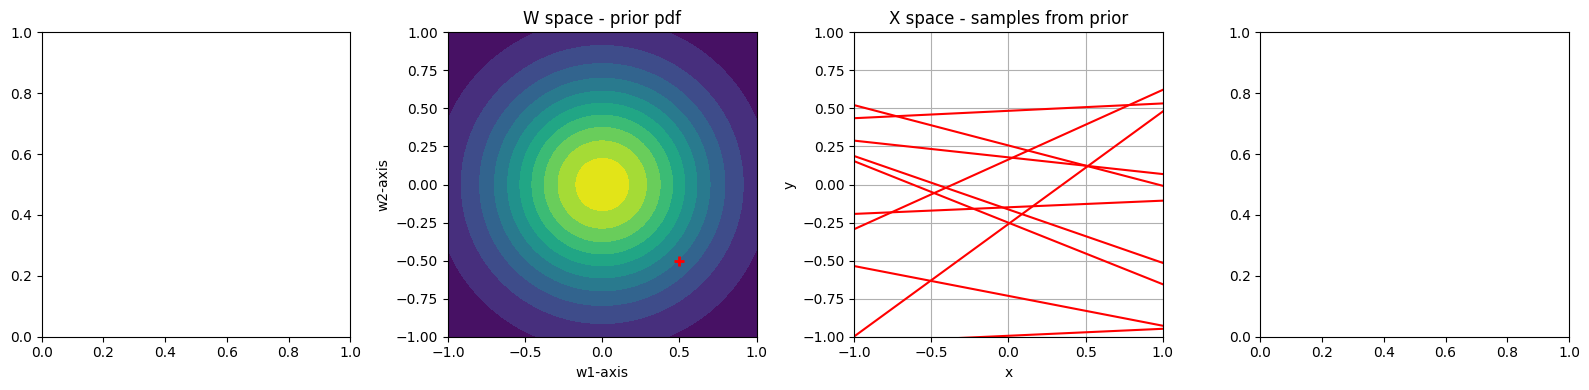

In [18]:
plot_prior(sigma0, plot_dot=plot_dot, w1min=w1min, w1max=w1max, w2min=w2min, w2max=w2max, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

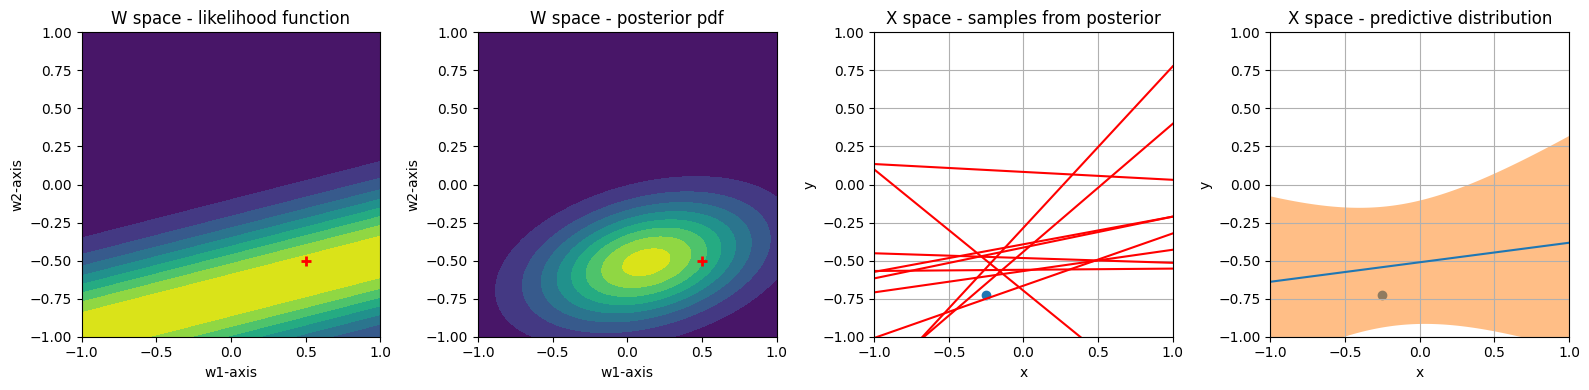

In [19]:
Ndata = 1
plot_predictions(X[:,:Ndata], y[:Ndata], sigma0, sigma, plot_dot=plot_dot, w1min=w1min, w1max=w1max, w2min=w2min, w2max=w2max, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

Two observations

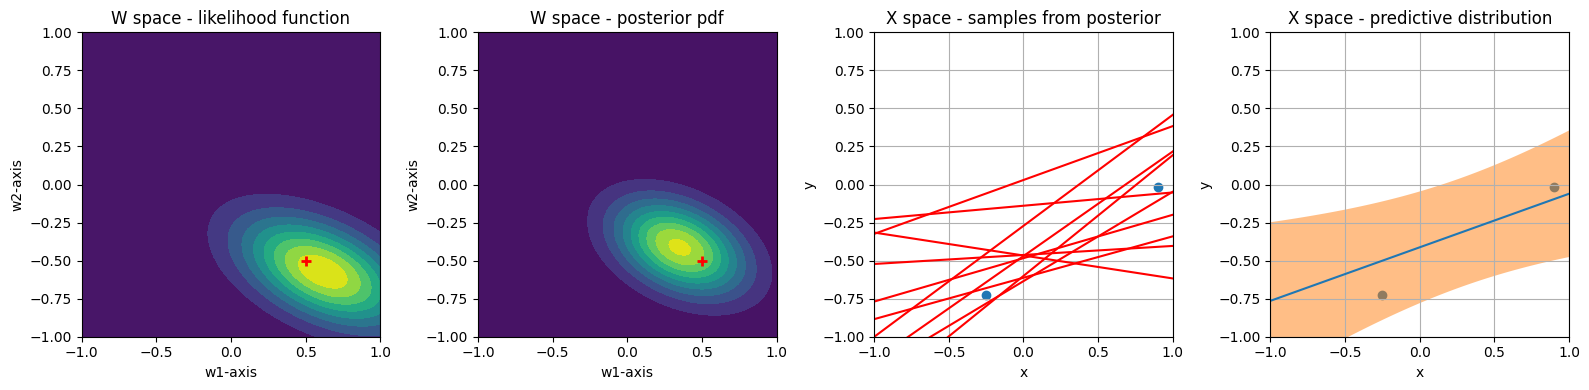

In [20]:
Ndata = 2
plot_predictions(X[:,:Ndata], y[:Ndata], sigma0, sigma, plot_dot=plot_dot, w1min=w1min, w1max=w1max, w2min=w2min, w2max=w2max, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

Twenty observations

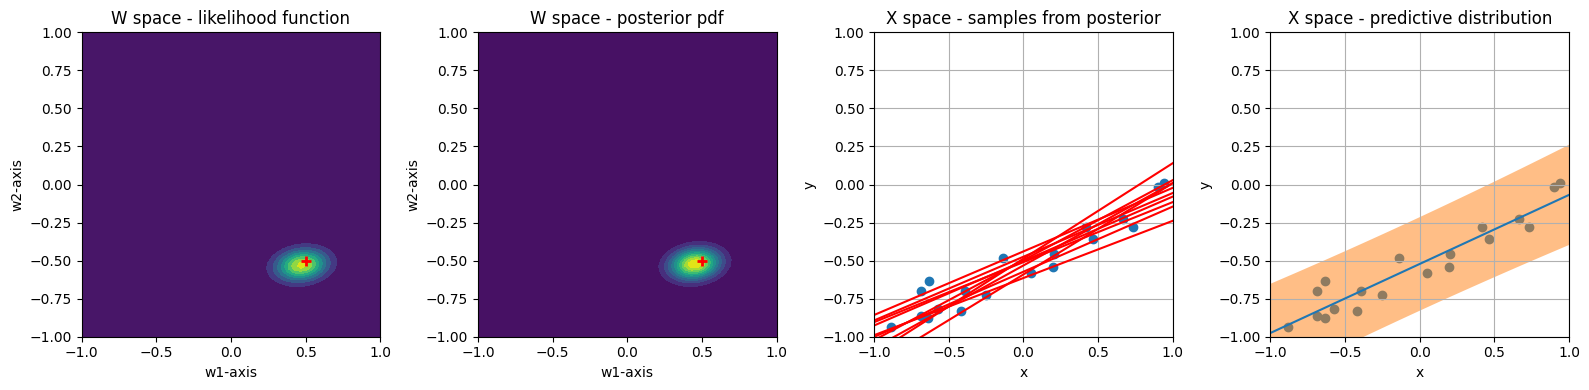

In [21]:
Ndata = 20
plot_predictions(X[:,:Ndata], y[:Ndata], sigma0, sigma, plot_dot=plot_dot, w1min=w1min, w1max=w1max, w2min=w2min, w2max=w2max, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)